# ResNet50 Layer Freezing Experiments and Best model training

### Pre-processing

In [1]:
RUN_MODE = "experiment"

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Absolute root where train/val/test exist after unzipping
DATA_ROOT = r'/kaggle/input/dementia-splits/final_dementia_split'

# Robust per-image normalization
def robust_normalize(image):
    image = image.astype(np.float32) / 255.0
    mask = image > 0
    pixels = image[mask]
    if pixels.size > 0:
        median = np.median(pixels)
        q25, q75 = np.percentile(pixels, [25, 75])
        iqr = q75 - q25
        if iqr > 0:
            image = (image - median) / iqr
    return image

# Data generators
def create_data_generators(batch_size=32):
    common_datagen = ImageDataGenerator(preprocessing_function=robust_normalize)

    train_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'train'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'validation'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'test'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

print('setup data pipeline successfully.')

2026-02-01 10:59:26.178986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769943566.394517      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769943566.458260      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769943566.998969      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769943566.999012      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769943566.999015      24 computation_placer.cc:177] computation placer alr

setup data pipeline successfully.


In [3]:
#from data_pipeline_setup import create_data_generators
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setup distributed training
strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPUs: 2
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


I0000 00:00:1769943583.348696      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769943583.354994      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## CONFIGURATION

In [4]:
class Config:
    """Experiment configuration"""
    # Data
    BATCH_SIZE = 32
    IMG_SIZE = (224, 224)
    NUM_CLASSES = 4
    CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

    # Training
    EPOCHS = 5
    LEARNING_RATE = None #will be set later

    # Paths
    RESULTS_DIR = '/kaggle/working/results/resnet50/'
    MODELS_DIR = '/kaggle/working/models/resnet50/'

    # Freezing configurations (absolute layer counts)
    FREEZE_CONFIGS = [
        {'name': 'freeze_all', 'layers': 177},
        {'name': 'freeze_150', 'layers': 150},
        {'name': 'freeze_100', 'layers': 100},
        {'name': 'freeze_50', 'layers': 50},
        {'name': 'freeze_25', 'layers': 25},
        {'name': 'freeze_none', 'layers': 0}
    ]

config = Config()

# Create directories
os.makedirs(config.RESULTS_DIR, exist_ok=True)
os.makedirs(config.MODELS_DIR, exist_ok=True)

print('setup config')

setup config


## DATA LOADING

In [5]:

print("\n" + "="*70)
print("LOADING DATA")
print("="*70)

# Load data using your preprocessing pipeline
# Replace this import with your actual preprocessing module
try:
    train_gen, val_gen, test_gen = create_data_generators(batch_size=config.BATCH_SIZE)
    print(f"✓ Data generators created successfully")
    print(f"  Train batches: {len(train_gen)}")
    print(f"  Val batches: {len(val_gen)}")
    print(f"  Test batches: {len(test_gen)}")
except Exception as e:
    print(f"✗ Error loading data: {e}")
    print("\nPlease ensure:")
    print("1. preprocessing.py exists with create_data_generators() function")
    print("2. Data directories are set up correctly")
    raise

# Test data pipeline
print("\nTesting data pipeline...")
try:
    sample_batch, sample_labels = next(iter(train_gen))
    print(f"✓ Sample batch shape: {sample_batch.shape}")
    print(f"✓ Sample labels shape: {sample_labels.shape}")
    print(f"✓ Image value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
    print(f"✓ Labels (first 5): {sample_labels[:5]}")
except Exception as e:
    print(f"✗ Data pipeline test failed: {e}")
    raise



LOADING DATA
Found 30800 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
✓ Data generators created successfully
  Train batches: 963
  Val batches: 207
  Test batches: 207

Testing data pipeline...
✓ Sample batch shape: (32, 224, 224, 3)
✓ Sample labels shape: (32, 4)
✓ Image value range: [-1.609, 2.087]
✓ Labels (first 5): [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


## MODEL ARCHITECTURE EXPLORATION

In [6]:

print("\n" + "="*70)
print("RESNET50 ARCHITECTURE EXPLORATION")
print("="*70)

# Load base model to explore architecture
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

print(f"\nTotal layers in ResNet50: {len(base_model.layers)}")
print("\nFirst 10 layers:")
for i in range(min(10, len(base_model.layers))):
    layer = base_model.layers[i]
    trainable_str = "trainable" if layer.trainable else "frozen"
    print(f"  {i:3d}. {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

print("\nLast 10 layers:")
for i in range(max(0, len(base_model.layers)-10), len(base_model.layers)):
    layer = base_model.layers[i]
    trainable_str = "trainable" if layer.trainable else "frozen"
    print(f"  {i:3d}. {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

# Save layer information
layer_info = []
for i, layer in enumerate(base_model.layers):
    layer_info.append({
        'index': i,
        'name': layer.name,
        'type': layer.__class__.__name__,
        'trainable': layer.trainable
    })

df_layers = pd.DataFrame(layer_info)
df_layers.to_csv(f'{config.RESULTS_DIR}/resnet50_layers.csv', index=False)
print(f"\n✓ Layer information saved to {config.RESULTS_DIR}/resnet50_layers.csv")
print('done')



RESNET50 ARCHITECTURE EXPLORATION
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Total layers in ResNet50: 175

First 10 layers:
    0. input_layer                    | InputLayer           | trainable
    1. conv1_pad                      | ZeroPadding2D        | trainable
    2. conv1_conv                     | Conv2D               | trainable
    3. conv1_bn                       | BatchNormalization   | trainable
    4. conv1_relu                     | Activation           | trainable
    5. pool1_pad                      | ZeroPadding2D        | trainable
    6. pool1_pool                     | MaxPooling2D         | trainable
    7. conv2_block1_1_conv            | Conv2D               | trainable
    8. conv2_block1_1_bn              | BatchNormalization   | trainable
    9. conv2_block1_1_relu            | Activation           | trainable

Last 10 layers:
  165. conv5_block3_1_conv            | Conv2D               | trainable
  166. conv5_block3_1_bn              | Batch

## MODEL CREATION FUNCTIONS

In [7]:
#learning rate when more layers are trainable needs to decrease accordingly
def get_learning_rate_for_config(num_frozen_layers, total_layers=175):
    trainable_layers = total_layers - num_frozen_layers
    trainable_ratio = trainable_layers / total_layers
    
    if trainable_ratio < 0.2:
        return 0.001
    elif trainable_ratio < 0.5:
        return 0.0005
    elif trainable_ratio < 0.8:
        return 0.0001
    else:
        return 0.00005

def create_model(num_frozen_layers=0, num_classes=4):
    """
    Create ResNet50 model with specified number of frozen layers

    Args:
        num_frozen_layers: Number of layers to freeze from the beginning (0-177)
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    # Load base model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze specified number of layers
    for i, layer in enumerate(base_model.layers):
        if i < num_frozen_layers:
            layer.trainable = False
        else:
            layer.trainable = True

    # Count trainable parameters
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    frozen_count = len(base_model.layers) - trainable_count

    # Build complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name=f'resnet50_freeze_{num_frozen_layers}')

    #set_learning_rate
    lr = get_learning_rate_for_config(num_frozen_layers)
    config.LEARNING_RATE = lr 
        
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nMODEL SUMMARY")
    print("=" * 70)
    model.summary()
    print("=" * 70)

    print(f"\n{'─'*70}")
    print(f"Model Created: Freeze {num_frozen_layers} layers")
    print(f"{'─'*70}")
    print(f"  Total base layers: {len(base_model.layers)}")
    print(f"  Frozen layers: {frozen_count}")
    print(f"  Trainable layers: {trainable_count}")
    print(f"  Trainable params: {model.count_params():,}")

    return model

print('created model')


created model


## TRAINING AND EVALUATION FUNCTION

In [8]:
def train_model(model, config_name, train_gen, val_gen, epochs=15):
    """
    Train model with callbacks and save results

    Args:
        model: Compiled Keras model
        config_name: Name of configuration (for saving)
        train_gen: Training data generator
        val_gen: Validation data generator
        epochs: Number of epochs

    Returns:
        history: Training history object
    """
    print(f"\n{'='*70}")
    print(f"TRAINING: {config_name}")
    print(f"{'='*70}")

    if RUN_MODE == "experiment":
        config.EPOCHS = 10
        STEPS_PER_EPOCH = 250
        VAL_STEPS = 100
    elif RUN_MODE == "final":
        config.EPOCHS = 50
        STEPS_PER_EPOCH = None
        VAL_STEPS = None
    else:
        raise ValueError("Invalid RUN_MODE")

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            filepath=f'{config.MODELS_DIR}/{config_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train
    start_time = datetime.now()

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config.EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = (datetime.now() - start_time).total_seconds() / 60

    print(f"\n✓ Training completed in {training_time:.2f} minutes")

    return history, training_time

def evaluate_model(model, config_name, history, training_time, val_gen):
    """
    Evaluate model and save results

    Args:
        model: Trained model
        config_name: Configuration name
        history: Training history
        training_time: Time taken to train (minutes)
        val_gen: Validation generator

    Returns:
        results: Dictionary of results
    """
    # Get best metrics from history
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    best_train_acc = history.history['accuracy'][best_epoch]
    final_val_loss = history.history['val_loss'][best_epoch]

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)

    results = {
        'config_name': config_name,
        'best_epoch': best_epoch + 1,
        'total_epochs': len(history.history['loss']),
        'best_train_accuracy': best_train_acc,
        'best_val_accuracy': best_val_acc,
        'final_val_loss': final_val_loss,
        'training_time_minutes': training_time
    }

    print(f"\n{'─'*70}")
    print(f"RESULTS: {config_name}")
    print(f"{'─'*70}")
    print(f"  Best Epoch: {results['best_epoch']}/{results['total_epochs']}")
    print(f"  Train Accuracy: {results['best_train_accuracy']:.4f}")
    print(f"  Val Accuracy: {results['best_val_accuracy']:.4f}")
    print(f"  Val Loss: {results['final_val_loss']:.4f}")
    print(f"  Training Time: {results['training_time_minutes']:.2f} min")

    # Save training curves
    plot_training_curves(history, config_name)

    return results

print('setup training and evaluation')

setup training and evaluation


## VISUALIZATION FUNCTIONS

In [9]:

def plot_training_curves(history, config_name):
    """Plot and save training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{config_name} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{config_name} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{config.RESULTS_DIR}/{config_name}_curves.png', dpi=150, bbox_inches='tight')
    plt.close()

def plot_comparison(results_df):
    """Plot comparison of all configurations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Sort by frozen layers
    results_df = results_df.sort_values('frozen_layers')

    # Accuracy comparison
    ax = axes[0, 0]
    x = range(len(results_df))
    ax.plot(x, results_df['best_train_accuracy'], marker='o', linewidth=2, markersize=8, label='Train Accuracy')
    ax.plot(x, results_df['best_val_accuracy'], marker='s', linewidth=2, markersize=8, label='Val Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Accuracy vs Frozen Layers', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Validation accuracy bar chart
    ax = axes[0, 1]
    bars = ax.bar(x, results_df['best_val_accuracy'], color='steelblue', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy by Configuration', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    # Highlight best
    best_idx = results_df['best_val_accuracy'].idxmax()
    bars[results_df.index.get_loc(best_idx)].set_color('green')

    # Training time
    ax = axes[1, 0]
    ax.bar(x, results_df['training_time_minutes'], color='coral', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Training Time (minutes)', fontsize=12)
    ax.set_title('Training Time by Configuration', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Overfitting analysis (train - val accuracy)
    ax = axes[1, 1]
    overfitting = results_df['best_train_accuracy'] - results_df['best_val_accuracy']
    bars = ax.bar(x, overfitting, color='orange', alpha=0.7)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='No Overfitting')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Train Acc - Val Acc', fontsize=12)
    ax.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{config.RESULTS_DIR}/comparison_all.png', dpi=150, bbox_inches='tight')
    plt.close()
    print(f"\n✓ Comparison plot saved to {config.RESULTS_DIR}/comparison_all.png")

print('setup viz')

setup viz


## MAIN EXPERIMENT LOOP

In [10]:
def run_all_experiments():
    """Run all layer freezing experiments"""

    print("\n" + "#"*70)
    print("STARTING RESNET50 LAYER FREEZING EXPERIMENTS")
    print("#"*70)
    print(f"\nTotal configurations to test: {len(config.FREEZE_CONFIGS)}")
    print(f"Expected total time: ~{len(config.FREEZE_CONFIGS) * 1.5:.1f} hours (avg 1.5h per config)")

    all_results = []

    for i, freeze_config in enumerate(config.FREEZE_CONFIGS, 1):
        config_name = freeze_config['name']
        num_frozen = freeze_config['layers']

        print(f"\n{'#'*70}")
        print(f"EXPERIMENT {i}/{len(config.FREEZE_CONFIGS)}: {config_name}")
        print(f"{'#'*70}")

        try:
            # Create model
            model = create_model(num_frozen_layers=num_frozen, num_classes=config.NUM_CLASSES)

            # Train model
            history, training_time = train_model(
                model=model,
                config_name=config_name,
                train_gen=train_gen,
                val_gen=val_gen,
                epochs=config.EPOCHS
            )

            # Evaluate and save results
            results = evaluate_model(
                model=model,
                config_name=config_name,
                history=history,
                training_time=training_time,
                val_gen=val_gen
            )

            # Add frozen layers info
            results['frozen_layers'] = num_frozen
            results['trainable_layers'] = len(base_model.layers) - num_frozen

            all_results.append(results)

            # Save intermediate results
            df_results = pd.DataFrame(all_results)
            df_results.to_csv(f'{config.RESULTS_DIR}/results_intermediate.csv', index=False)

            # Clear memory
            del model
            tf.keras.backend.clear_session()

            print(f"\n✓ Experiment {i}/{len(config.FREEZE_CONFIGS)} completed successfully")

        except Exception as e:
            print(f"\n✗ Experiment {config_name} failed: {e}")
            continue

    # Final results
    print("\n" + "#"*70)
    print("ALL EXPERIMENTS COMPLETED")
    print("#"*70)

    # Save final results
    df_results = pd.DataFrame(all_results)
    df_results = df_results.sort_values('best_val_accuracy', ascending=False)
    df_results.to_csv(f'{config.RESULTS_DIR}/results_final.csv', index=False)

    # Display summary
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(df_results[['config_name', 'frozen_layers', 'best_val_accuracy',
                      'best_train_accuracy', 'training_time_minutes']].to_string(index=False))

    # Best configuration
    best_config = df_results.iloc[0]
    print("\n" + "="*70)
    print("🏆 BEST CONFIGURATION")
    print("="*70)
    print(f"  Configuration: {best_config['config_name']}")
    print(f"  Frozen Layers: {best_config['frozen_layers']}/{len(base_model.layers)}")
    print(f"  Validation Accuracy: {best_config['best_val_accuracy']:.4f}")
    print(f"  Training Accuracy: {best_config['best_train_accuracy']:.4f}")
    print(f"  Overfitting Gap: {best_config['best_train_accuracy'] - best_config['best_val_accuracy']:.4f}")

    # Create comparison plots
    plot_comparison(df_results)

    # Save configuration
    with open(f'{config.RESULTS_DIR}/experiment_config.json', 'w') as f:
        json.dump({
            'batch_size': config.BATCH_SIZE,
            'epochs': config.EPOCHS,
            'learning_rate': config.LEARNING_RATE,
            'freeze_configs': config.FREEZE_CONFIGS,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    return df_results

print('done')

done


## MAIN TRAINING FUNCTION

In [11]:
def run_main_training(name, layers_freeze):
    """Run final model training"""

    print("\n" + "#"*70)
    print(f"STARTING RESNET50 MODEL TRAINING FREEZING {layers_freeze} layers")
    print("#"*70)
    
    all_results = []

    config_name = name
    num_frozen = layers_freeze

    try:
        # Create model
        model = create_model(num_frozen_layers=num_frozen, num_classes=config.NUM_CLASSES)

        # Train model
        history, training_time = train_model(
            model=model,
            config_name=config_name,
            train_gen=train_gen,
            val_gen=val_gen,
            epochs=config.EPOCHS
        )

        # Evaluate and save results
        results = evaluate_model(
            model=model,
            config_name=config_name,
            history=history,
            training_time=training_time,
            val_gen=val_gen
        )

        # Add frozen layers info
        results['frozen_layers'] = num_frozen
        results['trainable_layers'] = len(base_model.layers) - num_frozen

        all_results.append(results)

        # Save intermediate results
        df_results = pd.DataFrame(all_results)
        df_results.to_csv(f'{config.RESULTS_DIR}/results_intermediate_main.csv', index=False)

        # Clear memory
        del model
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"\n✗ Experiment {config_name} failed: {e}")

    # Final results
    print("\n" + "#"*70)
    print("TRAINING COMPLETED")
    print("#"*70)

    # Save final results
    df_results = pd.DataFrame(all_results)
    df_results = df_results.sort_values('best_val_accuracy', ascending=False)
    df_results.to_csv(f'{config.RESULTS_DIR}/results_main_model.csv', index=False)

    # Display summary
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(df_results[['config_name', 'frozen_layers', 'best_val_accuracy',
                      'best_train_accuracy', 'training_time_minutes']].to_string(index=False))

    # Save configuration
    with open(f'{config.RESULTS_DIR}/main_config.json', 'w') as f:
        json.dump({
            'batch_size': config.BATCH_SIZE,
            'epochs': config.EPOCHS,
            'learning_rate': config.LEARNING_RATE,
            'freeze_configs': config.FREEZE_CONFIGS,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    return df_results

print('done')

done


## BEST MODEL SELECTION FUNCTION

In [12]:
def select_best_model(results_df):
    """
    Intelligent model selection based on:
    1) Peak validation accuracy
    2) Elite group within 0.5% of peak
    3) Generalization gap (Train Acc - Val Acc)
    4) Winner: smallest gap
    5) Tiebreaker: lowest validation loss
    
    Args:
        df_results: DataFrame with experiment results containing columns:
                    - best_val_accuracy
                    - best_train_accuracy
                    - final_val_loss
                    - config_name
                    - frozen_layers
    
    Returns:
        dict: Selected model info with keys:
              - config_name, frozen_layers, best_val_accuracy, best_train_accuracy,
                final_val_loss, generalization_gap, selection_reason
    """
    
    # 1. Peak validation accuracy
    peak_val_acc = results_df['best_val_accuracy'].max()
    peak_val_loss = results_df.loc[results_df['best_val_accuracy'].idxmax(), 'final_val_loss']
    
    print("\n" + "="*70)
    print("MODEL SELECTION ALGORITHM")
    print("="*70)
    print(f"\n1. Peak Validation Accuracy: {peak_val_acc:.4f}")
    
    # 2. Define elite group (within 0.5% of peak)
    threshold = peak_val_acc * 0.995  # 0.5% tolerance
    elite_group = results_df[results_df['best_val_accuracy'] >= threshold].copy()
    
    print(f"\n2. Elite Group Threshold: {threshold:.4f}")
    print(f"   Models in elite group: {len(elite_group)}")
    for idx, row in elite_group.iterrows():
        gap = row['best_train_accuracy'] - row['best_val_accuracy']
        print(f"      - {row['config_name']:20s} | Val Acc: {row['best_val_accuracy']:.4f} | Gap: {gap:+.4f} | Val Loss: {row['final_val_loss']:.4f}")
    
    # 3. Calculate generalization gap for elite group
    elite_group['generalization_gap'] = elite_group['best_train_accuracy'] - elite_group['best_val_accuracy']
    elite_group['abs_gap'] = abs(elite_group['generalization_gap'])
    
    print(f"\n3. Generalization Gap Analysis (Train Acc - Val Acc):")
    for idx, row in elite_group.iterrows():
        print(f"   {row['config_name']:20s} : {row['generalization_gap']:+.4f} (abs: {row['abs_gap']:.4f})")

    # 4. Select winner: smallest absolute gap (closest to zero)
    winner_idx = elite_group['abs_gap'].idxmin()
    winner = elite_group.loc[winner_idx]
    
    selection_reason = f"Smallest abs gap ({winner['generalization_gap']:+.4f})"
    
    # 5. Tiebreaker: if multiple models with same gap, pick lowest val loss
    same_gap = elite_group[elite_group['abs_gap'] == elite_group['abs_gap'].min()]
    if len(same_gap) > 1:
        winner_idx = same_gap['final_val_loss'].idxmin()
        winner = elite_group.loc[winner_idx]
        selection_reason += f", tied → lowest val loss ({winner['final_val_loss']:.4f})"
    
    print("\n" + "="*70)
    print("SELECTED MODEL FOR FINAL TRAINING")
    print("="*70)
    print(f"  Configuration: {winner['config_name']}")
    print(f"  Frozen Layers: {winner['frozen_layers']}")
    print(f"  Val Accuracy: {winner['best_val_accuracy']:.4f}")
    print(f"  Train Accuracy: {winner['best_train_accuracy']:.4f}")
    print(f"  Generalization Gap: {winner['generalization_gap']:.4f}")
    print(f"  Val Loss: {winner['final_val_loss']:.4f}")
    print(f"  Selection Reason: {selection_reason}")
    print("="*70 + "\n")
    
    return {
        'config_name': winner['config_name'],
        'frozen_layers': int(winner['frozen_layers']),
        'best_val_accuracy': winner['best_val_accuracy'],
        'best_train_accuracy': winner['best_train_accuracy'],
        'final_val_loss': winner['final_val_loss'],
        'generalization_gap': winner['generalization_gap'],
        'selection_reason': selection_reason
    }

print('setup model selection function')

setup model selection function


## QUICK TEST FUNCTION

In [13]:

def test_pipeline():
    """Quick test to verify everything works before running full experiments"""
    print("\n" + "="*70)
    print("RUNNING PIPELINE TEST")
    print("="*70)

    try:
        # Test data loading
        print("\n1. Testing data loading...")
        batch, labels = next(iter(train_gen))
        print(f"   ✓ Data batch loaded: {batch.shape}")

        # Test model creation
        print("\n2. Testing model creation...")
        test_model = create_model(num_frozen_layers=100)
        print(f"   ✓ Model created successfully")

        # Test single epoch
        print("\n3. Testing single training epoch...")
        history = test_model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=1)
        print(f"   ✓ Training epoch completed")
        print(f"   Train accuracy: {history.history['accuracy'][0]:.4f}")
        print(f"   Val accuracy: {history.history['val_accuracy'][0]:.4f}")

        print("\n" + "="*70)
        print("✓ PIPELINE TEST PASSED - READY TO RUN FULL EXPERIMENTS")
        print("="*70)

        # Clean up
        del test_model
        tf.keras.backend.clear_session()

        return True

    except Exception as e:
        print(f"\n✗ PIPELINE TEST FAILED: {e}")
        print("\nPlease fix the issue before running full experiments")
        return False

print('setup pipeline')

setup pipeline


## MAIN EXECUTION

In [14]:
# Run experiments
results_df = run_all_experiments()

print("\nEXPERIMENTS COMPLETE!")
print(f"Results saved to: {config.RESULTS_DIR}")
print(f"Models saved to: {config.MODELS_DIR}")


######################################################################
STARTING RESNET50 LAYER FREEZING EXPERIMENTS
######################################################################

Total configurations to test: 6
Expected total time: ~9.0 hours (avg 1.5h per config)

######################################################################
EXPERIMENT 1/6: freeze_all
######################################################################

MODEL SUMMARY


Model: "resnet50_freeze_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 177 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 175
  Trainable layers: 0
  Trainable params: 24,113,284

TRAINING: freeze_all


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1769943613.369518      69 service.cc:152] XLA service 0x7e6698003b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769943613.369555      69 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769943613.369559      69 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769943615.339930      69 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/250 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.1094 - loss: 2.0576 

I0000 00:00:1769943620.736961      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3439 - loss: 1.4124
Epoch 1: val_accuracy improved from -inf to 0.52781, saving model to /kaggle/working/models/resnet50//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 385ms/step - accuracy: 0.3440 - loss: 1.4119 - val_accuracy: 0.5278 - val_loss: 1.2326 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4532 - loss: 1.1849
Epoch 2: val_accuracy improved from 0.52781 to 0.64031, saving model to /kaggle/working/models/resnet50//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 262ms/step - accuracy: 0.4532 - loss: 1.1848 - val_accuracy: 0.6403 - val_loss: 1.0390 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4769 - loss: 1.1282
Epoch 3: val_accuracy did not improve from 0.64031
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 234ms/step - accuracy: 0.4769 - loss: 1.1282 - val_accuracy: 0.5816 - val_loss: 1.0592 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.5000 - loss: 1.1027

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.64031
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - accuracy: 0.5006 - loss: 1.1012 - val_accuracy: 0.5738 - val_loss: 1.0319 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5164 - loss: 1.0596
Epoch 5: val_accuracy improved from 0.64031 to 0.66781, saving model to /kaggle/working/models/resnet50//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 231ms/step - accuracy: 0.5164 - loss: 1.0596 - val_accuracy: 0.6678 - val_loss: 0.8861 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5231 - loss: 1.0335
Epoch 6: val_accuracy did not improve from 0.66781
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 218ms/step - accuracy: 0.5231 - loss: 1.0335 - val_accuracy: 0.5938 - val_loss: 1.0741 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5435 - loss: 1.0109
Epoch 7: val_accuracy improved from 0.66781 to 0.75313, saving model to /kaggle/working/models/resnet50//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 214ms/step - accuracy: 0.5435 - loss: 1.0108 - val_accuracy: 0.7531 - val_loss: 0.8235 - learning_rate: 0.0010
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.5408 - loss: 0.9874
Epoch 8: val_accuracy improved from 0.75313 to 0.76156, saving model to /kaggle/working/models/resnet50//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.5407 - loss: 0.9887 - val_accuracy: 0.7616 - val_loss: 0.8299 - learning_rate: 0.0010
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5530 - loss: 0.9803
Epoch 9: val_accuracy did not improve from 0.76156
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.5530 - loss: 0.9803 - val_accuracy: 0.6056 - val_loss: 0.9100 - learning_rate: 0.0010
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5518 - loss: 0.9778
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_accuracy did not improve from 0.76156
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.5519 - loss: 0.9777 - val_accuracy: 0.6341 - val_loss: 0.9554 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 7.

✓ Training completed in 9.92 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_all
─────────────────────

Model: "resnet50_freeze_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 10,515,716 (40.11 MB)

 Non-trainable params: 13,597,568 (51.87 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 150 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 150
  Trainable layers: 25
  Trainable params: 24,113,284

TRAINING: freeze_150
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4694 - loss: 1.1811
Epoch 1: val_accuracy improved from -inf to 0.83188, saving model to /kaggle/working/models/resnet50//freeze_150_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 220ms/step - accuracy: 0.4697 - loss: 1.1804 - val_accuracy: 0.8319 - val_loss: 0.6292 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6320 - loss: 0.8005
Epoch 2: val_accuracy did not improve from 0.83188
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.6320 - loss: 0.8005 - val_accuracy: 0.5497 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6544 - loss: 0.7505
Epoch 3: val_accuracy improved from 0.83188 to 0.87656, saving model to /kaggle/working/models/resnet50//freeze_150_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.6544 - loss: 0.7504 - val_accuracy: 0.8766 - val_loss: 0.3408 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.6844 - loss: 0.7032
Epoch 4: val_accuracy did not improve from 0.87656
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.6851 - loss: 0.7030 - val_accuracy: 0.6397 - val_loss: 0.8100 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7056 - loss: 0.6548
Epoch 5: val_accuracy improved from 0.87656 to 0.91375, saving model to /kaggle/working/models/resnet50//freeze_150_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.7056 - loss: 0.6548 - val_accuracy: 0.9137 - val_loss: 0.2694 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7326 - loss: 0.6100
Epoch 6: val_accuracy improved from 0.91375 to 0.94031, saving model to /kaggle/working/models/resnet50//freeze_150_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.7326 - loss: 0.6100 - val_accuracy: 0.9403 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7509 - loss: 0.5796
Epoch 7: val_accuracy did not improve from 0.94031
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.7509 - loss: 0.5796 - val_accuracy: 0.9312 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7747 - loss: 0.5389
Epoch 8: val_accuracy did not improve from 0.94031
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.7737 - loss: 0.5400 - val_accuracy: 0.8512 - val_loss: 0.4462 - learning_rate: 0.0010
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7823 - loss: 0.5022
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_accuracy did not improve from 0.94031
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - accuracy: 0.7824 - loss: 0.5

Model: "resnet50_freeze_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 19,978,500 (76.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 100 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 100
  Trainable layers: 75
  Trainable params: 24,113,284

TRAINING: freeze_100
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5043 - loss: 1.1150
Epoch 1: val_accuracy improved from -inf to 0.54875, saving model to /kaggle/working/models/resnet50//freeze_100_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 266ms/step - accuracy: 0.5045 - loss: 1.1143 - val_accuracy: 0.5487 - val_loss: 6.6636 - learning_rate: 5.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6280 - loss: 0.7701
Epoch 2: val_accuracy improved from 0.54875 to 0.71906, saving model to /kaggle/working/models/resnet50//freeze_100_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 246ms/step - accuracy: 0.6281 - loss: 0.7700 - val_accuracy: 0.7191 - val_loss: 0.9791 - learning_rate: 5.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6936 - loss: 0.6994
Epoch 3: val_accuracy improved from 0.71906 to 0.84156, saving model to /kaggle/working/models/resnet50//freeze_100_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 241ms/step - accuracy: 0.6936 - loss: 0.6992 - val_accuracy: 0.8416 - val_loss: 0.7342 - learning_rate: 5.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.7164 - loss: 0.6105
Epoch 4: val_accuracy did not improve from 0.84156
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 269ms/step - accuracy: 0.7172 - loss: 0.6104 - val_accuracy: 0.6091 - val_loss: 2.1876 - learning_rate: 5.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7683 - loss: 0.5363
Epoch 5: val_accuracy improved from 0.84156 to 0.90188, saving model to /kaggle/working/models/resnet50//freeze_100_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 234ms/step - accuracy: 0.7683 - loss: 0.5364 - val_accuracy: 0.9019 - val_loss: 0.2291 - learning_rate: 5.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7864 - loss: 0.5022
Epoch 6: val_accuracy did not improve from 0.90188
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 234ms/step - accuracy: 0.7865 - loss: 0.5022 - val_accuracy: 0.7156 - val_loss: 0.7807 - learning_rate: 5.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8118 - loss: 0.4483
Epoch 7: val_accuracy improved from 0.90188 to 0.92375, saving model to /kaggle/working/models/resnet50//freeze_100_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 235ms/step - accuracy: 0.8119 - loss: 0.4482 - val_accuracy: 0.9237 - val_loss: 0.2744 - learning_rate: 5.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.8296 - loss: 0.4716
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: val_accuracy did not improve from 0.92375
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 206ms/step - accuracy: 0.8311 - loss: 0.4621 - val_accuracy: 0.8422 - val_loss: 0.4488 - learning_rate: 5.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8780 - loss: 0.3131
Epoch 9: val_accuracy improved from 0.92375 to 0.95969, saving model to /kaggle/working/models/resnet50//freeze_100_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 237ms/step - accuracy: 0.8780 - loss: 0.3130 - val_accuracy: 0.9597 - val_loss: 0.1159 - learning_rate: 2.5000e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9032 - loss: 0.2486
Epoch 10: val_accuracy improved from 0.95969 to 0.98250, saving model to /kaggle/working/models/resnet50//freeze_100_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 236ms/step - accuracy: 0.9032 - loss: 0.2486 - val_accuracy: 0.9825 - val_loss: 0.0587 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 10.58 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_100
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.9126
  Val Accuracy: 0.9825
  Val Loss: 0.0587
  Training Time: 10.58 min

✓ Experiment 3/6 completed successfully

######################################################################
EXPERIMENT 4/6: freeze_50
######################################################################

MODEL SUMMARY


Model: "resnet50_freeze_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 23,452,676 (89.46 MB)

 Non-trainable params: 660,608 (2.52 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 50 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 50
  Trainable layers: 125
  Trainable params: 24,113,284

TRAINING: freeze_50
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5458 - loss: 0.9980
Epoch 1: val_accuracy improved from -inf to 0.87969, saving model to /kaggle/working/models/resnet50//freeze_50_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 331ms/step - accuracy: 0.5462 - loss: 0.9971 - val_accuracy: 0.8797 - val_loss: 0.3371 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7923 - loss: 0.5018
Epoch 2: val_accuracy improved from 0.87969 to 0.97625, saving model to /kaggle/working/models/resnet50//freeze_50_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 310ms/step - accuracy: 0.7924 - loss: 0.5016 - val_accuracy: 0.9762 - val_loss: 0.0734 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8796 - loss: 0.3050
Epoch 3: val_accuracy did not improve from 0.97625
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 303ms/step - accuracy: 0.8796 - loss: 0.3049 - val_accuracy: 0.8888 - val_loss: 0.3114 - learning_rate: 1.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.9204 - loss: 0.2244
Epoch 4: val_accuracy did not improve from 0.97625
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 366ms/step - accuracy: 0.9205 - loss: 0.2228 - val_accuracy: 0.9631 - val_loss: 0.0978 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9464 - loss: 0.1502
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 5: val_accuracy did not improve from 0.97625
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 300ms/step - accuracy: 0.946

250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 304ms/step - accuracy: 0.9590 - loss: 0.1135 - val_accuracy: 0.9772 - val_loss: 0.0661 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9836 - loss: 0.0503
Epoch 7: val_accuracy did not improve from 0.97719
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 300ms/step - accuracy: 0.9836 - loss: 0.0503 - val_accuracy: 0.9756 - val_loss: 0.0755 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9853 - loss: 0.0438
Epoch 8: val_accuracy improved from 0.97719 to 0.99750, saving model to /kaggle/working/models/resnet50//freeze_50_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 272ms/step - accuracy: 0.9851 - loss: 0.0437 - val_accuracy: 0.9975 - val_loss: 0.0109 - learning_rate: 5.0000e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9875 - loss: 0.0426
Epoch 9: val_accuracy did not improve from 0.99750
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 302ms/step - accuracy: 0.9875 - loss: 0.0426 - val_accuracy: 0.9916 - val_loss: 0.0216 - learning_rate: 5.0000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9915 - loss: 0.0278
Epoch 10: val_accuracy did not improve from 0.99750
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step - accuracy: 0.9915 - loss: 0.0278 - val_accuracy: 0.9909 - val_loss: 0.0292 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 8.

✓ Training completed in 13.75 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_50
──────────────────────────────────────────────────────────────────────
  Best Epoch: 8/

Model: "resnet50_freeze_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 23,921,284 (91.25 MB)

 Non-trainable params: 192,000 (750.00 KB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 25 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 25
  Trainable layers: 150
  Trainable params: 24,113,284

TRAINING: freeze_25
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.5484 - loss: 1.0260
Epoch 1: val_accuracy improved from -inf to 0.89344, saving model to /kaggle/working/models/resnet50//freeze_25_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 179s 477ms/step - accuracy: 0.5489 - loss: 1.0249 - val_accuracy: 0.8934 - val_loss: 0.3155 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8193 - loss: 0.4313
Epoch 2: val_accuracy improved from 0.89344 to 0.91125, saving model to /kaggle/working/models/resnet50//freeze_25_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 351ms/step - accuracy: 0.8194 - loss: 0.4311 - val_accuracy: 0.9112 - val_loss: 0.2278 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9154 - loss: 0.2306
Epoch 3: val_accuracy improved from 0.91125 to 0.97688, saving model to /kaggle/working/models/resnet50//freeze_25_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 349ms/step - accuracy: 0.9154 - loss: 0.2306 - val_accuracy: 0.9769 - val_loss: 0.0616 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.9458 - loss: 0.1503
Epoch 4: val_accuracy improved from 0.97688 to 0.99063, saving model to /kaggle/working/models/resnet50//freeze_25_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 307ms/step - accuracy: 0.9457 - loss: 0.1499 - val_accuracy: 0.9906 - val_loss: 0.0310 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9609 - loss: 0.1140
Epoch 5: val_accuracy improved from 0.99063 to 0.99187, saving model to /kaggle/working/models/resnet50//freeze_25_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 351ms/step - accuracy: 0.9609 - loss: 0.1140 - val_accuracy: 0.9919 - val_loss: 0.0284 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9674 - loss: 0.0867
Epoch 6: val_accuracy did not improve from 0.99187
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 346ms/step - accuracy: 0.9674 - loss: 0.0867 - val_accuracy: 0.9744 - val_loss: 0.0682 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9781 - loss: 0.0592
Epoch 7: val_accuracy did not improve from 0.99187
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 344ms/step - accuracy: 0.9781 - loss: 0.0592 - val_accuracy: 0.9691 - val_loss: 0.0846 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 10s 295ms/step - accuracy: 0.9827 - loss: 0.0512
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_accuracy did not improve from 0.99187
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 300ms/step - accuracy: 0.982

250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 362ms/step - accuracy: 0.9885 - loss: 0.0376 - val_accuracy: 0.9962 - val_loss: 0.0129 - learning_rate: 2.5000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9923 - loss: 0.0222
Epoch 10: val_accuracy did not improve from 0.99625
250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 355ms/step - accuracy: 0.9923 - loss: 0.0222 - val_accuracy: 0.9959 - val_loss: 0.0106 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 15.75 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_25
──────────────────────────────────────────────────────────────────────
  Best Epoch: 9/10
  Train Accuracy: 0.9904
  Val Accuracy: 0.9962
  Val Loss: 0.0129
  Training Time: 15.75 min

✓ Experiment 5/6 completed successfully

######################################################################
EXPERIMENT 6/6: freeze_none
################################################

Model: "resnet50_freeze_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 24,060,164 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 0 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 0
  Trainable layers: 175
  Trainable params: 24,113,284

TRAINING: freeze_none
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5182 - loss: 1.1000
Epoch 1: val_accuracy improved from -inf to 0.00219, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 172s 419ms/step - accuracy: 0.5186 - loss: 1.0990 - val_accuracy: 0.0022 - val_loss: 2.4444 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7930 - loss: 0.4935
Epoch 2: val_accuracy improved from 0.00219 to 0.43375, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 406ms/step - accuracy: 0.7931 - loss: 0.4933 - val_accuracy: 0.4338 - val_loss: 1.3393 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9006 - loss: 0.2680
Epoch 3: val_accuracy improved from 0.43375 to 0.91125, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.9006 - loss: 0.2680 - val_accuracy: 0.9112 - val_loss: 0.2407 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.9379 - loss: 0.1695
Epoch 4: val_accuracy improved from 0.91125 to 0.96219, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 350ms/step - accuracy: 0.9381 - loss: 0.1687 - val_accuracy: 0.9622 - val_loss: 0.1196 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9580 - loss: 0.1187
Epoch 5: val_accuracy improved from 0.96219 to 0.98875, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 403ms/step - accuracy: 0.9580 - loss: 0.1187 - val_accuracy: 0.9887 - val_loss: 0.0391 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9644 - loss: 0.0968
Epoch 6: val_accuracy did not improve from 0.98875
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 399ms/step - accuracy: 0.9644 - loss: 0.0968 - val_accuracy: 0.9722 - val_loss: 0.0865 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9778 - loss: 0.0621
Epoch 7: val_accuracy did not improve from 0.98875
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 396ms/step - accuracy: 0.9778 - loss: 0.0621 - val_accuracy: 0.9825 - val_loss: 0.0436 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 12s 343ms/step - accuracy: 0.9800 - loss: 0.0687
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_accuracy did not improve from 0.98875
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 345ms/step - accuracy: 0.9

250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 401ms/step - accuracy: 0.9845 - loss: 0.0421 - val_accuracy: 0.9916 - val_loss: 0.0298 - learning_rate: 2.5000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9959 - loss: 0.0159
Epoch 10: val_accuracy improved from 0.99156 to 0.99719, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 402ms/step - accuracy: 0.9959 - loss: 0.0159 - val_accuracy: 0.9972 - val_loss: 0.0082 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 17.90 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_none
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.9942
  Val Accuracy: 0.9972
  Val Loss: 0.0082
  Training Time: 17.90 min

✓ Experiment 6/6 completed successfully

######################################################################
ALL EXPERIMENTS COMPLETED
######################################################################

FINAL RESULTS SUMMARY
config_name  frozen_layers  best_val_accuracy  best_train_accuracy  training_time_minutes
  freeze_50             50           0.997500             0.984448              13.749078
freeze_none              0           0.997187             0.9

## NEW LAYER FREEZING STRATEGY

Objective: To efficiently determine the optimal number of layers to unfreeze for maximum model performance.

Previous Approach: The initial plan was to test unfreezing layers one by one (e.g., freeze_1, freeze_2, etc.). This is computationally expensive and doesn't align with the model's internal architecture.

New, Principled Approach: Block-Wise Fine-Tuning

We are shifting to a more strategic method based on the ResNet model's design.

Models are Built in Blocks: ResNet isn't a simple stack of layers; it's composed of functional blocks (e.g., conv2_x, conv3_x, conv4_x). Each block is responsible for learning features at a specific level of complexity.

Fine-Tuning from the Top Down: The standard and most effective practice is to unfreeze these blocks sequentially, starting from the final, most specialized block and working backward toward the initial, more general ones.

Efficient Experimentation: This reduces our experiments from a potential 175+ to just 3-5 key configurations. This will allow us to scientifically locate the performance "sweet spot" with minimal computational cost.

This new strategy is faster, more systematic, and provides more meaningful insights into how fine-tuning affects our model's feature learning.

In [15]:
config.FREEZE_CONFIGS = [
        {'name': 'freeze_conv5', 'layers': 174},
        {'name': 'freeze_conv4', 'layers': 142},
        {'name': 'freeze_conv3', 'layers': 80},
        {'name': 'freeze_conv2', 'layers': 38},
        {'name': 'freeze_conv1', 'layers': 6},
        {'name': 'freeze_none', 'layers': 0}
    ]

print('changed freeze layer config')

changed freeze layer config


In [16]:
##run again
results_df = run_all_experiments()

print("\nEXPERIMENTS COMPLETE!")
print(f"Results saved to: {config.RESULTS_DIR}")
print(f"Models saved to: {config.MODELS_DIR}")


######################################################################
STARTING RESNET50 LAYER FREEZING EXPERIMENTS
######################################################################

Total configurations to test: 6
Expected total time: ~9.0 hours (avg 1.5h per config)

######################################################################
EXPERIMENT 1/6: freeze_conv5
######################################################################

MODEL SUMMARY


Model: "resnet50_freeze_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 174 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 174
  Trainable layers: 1
  Trainable params: 24,113,284

TRAINING: freeze_conv5
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3457 - loss: 1.4078
Epoch 1: val_accuracy improved from -inf to 0.44125, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 213ms/step - accuracy: 0.3458 - loss: 1.4074 - val_accuracy: 0.4412 - val_loss: 1.3001 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4239 - loss: 1.2099
Epoch 2: val_accuracy improved from 0.44125 to 0.59906, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 206ms/step - accuracy: 0.4240 - loss: 1.2098 - val_accuracy: 0.5991 - val_loss: 1.1063 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4727 - loss: 1.1408
Epoch 3: val_accuracy improved from 0.59906 to 0.63531, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.4727 - loss: 1.1408 - val_accuracy: 0.6353 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.4873 - loss: 1.0998

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.63531
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.4880 - loss: 1.0993 - val_accuracy: 0.6094 - val_loss: 1.0702 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4990 - loss: 1.0715
Epoch 5: val_accuracy improved from 0.63531 to 0.72031, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 206ms/step - accuracy: 0.4990 - loss: 1.0715 - val_accuracy: 0.7203 - val_loss: 0.9680 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5068 - loss: 1.0565
Epoch 6: val_accuracy improved from 0.72031 to 0.72438, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.5068 - loss: 1.0565 - val_accuracy: 0.7244 - val_loss: 0.9008 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5364 - loss: 1.0342
Epoch 7: val_accuracy did not improve from 0.72438
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.5364 - loss: 1.0341 - val_accuracy: 0.7022 - val_loss: 0.9120 - learning_rate: 0.0010
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.5543 - loss: 1.0062
Epoch 8: val_accuracy improved from 0.72438 to 0.74125, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.5529 - loss: 1.0075 - val_accuracy: 0.7412 - val_loss: 0.7965 - learning_rate: 0.0010
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5591 - loss: 0.9884
Epoch 9: val_accuracy improved from 0.74125 to 0.76250, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.5591 - loss: 0.9884 - val_accuracy: 0.7625 - val_loss: 0.8569 - learning_rate: 0.0010
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5594 - loss: 0.9819
Epoch 10: val_accuracy improved from 0.76250 to 0.85031, saving model to /kaggle/working/models/resnet50//freeze_conv5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.5595 - loss: 0.9819 - val_accuracy: 0.8503 - val_loss: 0.6686 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 8.34 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv5
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.5629
  Val Accuracy: 0.8503
  Val Loss: 0.6686
  Training Time: 8.34 min

✓ Experiment 1/6 completed successfully

######################################################################
EXPERIMENT 2/6: freeze_conv4
######################################################################

MODEL SUMMARY


Model: "resnet50_freeze_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 15,501,572 (59.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 142 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 142
  Trainable layers: 33
  Trainable params: 24,113,284

TRAINING: freeze_conv4
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4507 - loss: 1.2292
Epoch 1: val_accuracy improved from -inf to 0.49437, saving model to /kaggle/working/models/resnet50//freeze_conv4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 264ms/step - accuracy: 0.4509 - loss: 1.2285 - val_accuracy: 0.4944 - val_loss: 9.5286 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5949 - loss: 0.8538
Epoch 2: val_accuracy improved from 0.49437 to 0.73531, saving model to /kaggle/working/models/resnet50//freeze_conv4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.5949 - loss: 0.8537 - val_accuracy: 0.7353 - val_loss: 1.0906 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6435 - loss: 0.7771
Epoch 3: val_accuracy improved from 0.73531 to 0.86844, saving model to /kaggle/working/models/resnet50//freeze_conv4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.6435 - loss: 0.7771 - val_accuracy: 0.8684 - val_loss: 0.4222 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.6739 - loss: 0.7294
Epoch 4: val_accuracy did not improve from 0.86844
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.6718 - loss: 0.7316 - val_accuracy: 0.4978 - val_loss: 1.4063 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6578 - loss: 0.7422
Epoch 5: val_accuracy did not improve from 0.86844
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.6579 - loss: 0.7422 - val_accuracy: 0.6328 - val_loss: 1.1128 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6801 - loss: 0.6905
Epoch 6: val_accuracy improved from 0.86844 to 0.93469, saving model to /kaggle/working/models/resnet50//freeze_conv4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 198ms/step - accuracy: 0.6801 - loss: 0.6905 - val_accuracy: 0.9347 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7075 - loss: 0.6403
Epoch 7: val_accuracy did not improve from 0.93469
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.7075 - loss: 0.6402 - val_accuracy: 0.8222 - val_loss: 0.4351 - learning_rate: 0.0010
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7136 - loss: 0.6413
Epoch 8: val_accuracy did not improve from 0.93469
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.7139 - loss: 0.6390 - val_accuracy: 0.8253 - val_loss: 0.5125 - learning_rate: 0.0010
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7212 - loss: 0.6076
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_accuracy did not improve from 0.93469
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.7212 - loss: 0.6

250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.7529 - loss: 0.5671 - val_accuracy: 0.9356 - val_loss: 0.1785 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 8.57 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv4
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.7629
  Val Accuracy: 0.9356
  Val Loss: 0.1785
  Training Time: 8.57 min

✓ Experiment 2/6 completed successfully

######################################################################
EXPERIMENT 3/6: freeze_conv3
######################################################################

MODEL SUMMARY


Model: "resnet50_freeze_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 22,610,180 (86.25 MB)

 Non-trainable params: 1,503,104 (5.73 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 80 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 80
  Trainable layers: 95
  Trainable params: 24,113,284

TRAINING: freeze_conv3
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5436 - loss: 1.0090
Epoch 1: val_accuracy improved from -inf to 0.75375, saving model to /kaggle/working/models/resnet50//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 286ms/step - accuracy: 0.5440 - loss: 1.0082 - val_accuracy: 0.7538 - val_loss: 0.6752 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7616 - loss: 0.5538
Epoch 2: val_accuracy improved from 0.75375 to 0.91938, saving model to /kaggle/working/models/resnet50//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.7617 - loss: 0.5536 - val_accuracy: 0.9194 - val_loss: 0.2305 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8456 - loss: 0.3745
Epoch 3: val_accuracy improved from 0.91938 to 0.97250, saving model to /kaggle/working/models/resnet50//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 341ms/step - accuracy: 0.8456 - loss: 0.3744 - val_accuracy: 0.9725 - val_loss: 0.0807 - learning_rate: 1.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8932 - loss: 0.2751
Epoch 4: val_accuracy did not improve from 0.97250
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 235ms/step - accuracy: 0.8935 - loss: 0.2747 - val_accuracy: 0.9628 - val_loss: 0.1084 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9288 - loss: 0.1953
Epoch 5: val_accuracy did not improve from 0.97250
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.9288 - loss: 0.1953 - val_accuracy: 0.9525 - val_loss: 0.1268 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9525 - loss: 0.1405
Epoch 6: val_accuracy improved from 0.97250 to 0.98219, saving model to /kaggle/working/models/resnet50//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.9525 - loss: 0.1405 - val_accuracy: 0.9822 - val_loss: 0.0525 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9541 - loss: 0.1199
Epoch 7: val_accuracy improved from 0.98219 to 0.98687, saving model to /kaggle/working/models/resnet50//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 274ms/step - accuracy: 0.9541 - loss: 0.1199 - val_accuracy: 0.9869 - val_loss: 0.0394 - learning_rate: 1.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.9630 - loss: 0.0967
Epoch 8: val_accuracy did not improve from 0.98687
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.9627 - loss: 0.0977 - val_accuracy: 0.9369 - val_loss: 0.1693 - learning_rate: 1.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9689 - loss: 0.0894
Epoch 9: val_accuracy improved from 0.98687 to 0.99187, saving model to /kaggle/working/models/resnet50//freeze_conv3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.9689 - loss: 0.0894 - val_accuracy: 0.9919 - val_loss: 0.0263 - learning_rate: 1.0000e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9738 - loss: 0.0845
Epoch 10: val_accuracy did not improve from 0.99187
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 262ms/step - accuracy: 0.9738 - loss: 0.0845 - val_accuracy: 0.9906 - val_loss: 0.0253 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 11.88 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv3
──────────────────────────────────────────────────────────────────────
  Best Epoch: 9/10
  Train Accuracy: 0.9685
  Val Accuracy: 0.9919
  Val Loss: 0.0263
  Training Time: 11.88 min

✓ Experiment 3/6 completed successfully

######################################################################
EXPERIMENT 4/6: freeze_conv2
############################################

Model: "resnet50_freeze_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 23,833,348 (90.92 MB)

 Non-trainable params: 279,936 (1.07 MB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 38 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 38
  Trainable layers: 137
  Trainable params: 24,113,284

TRAINING: freeze_conv2
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5910 - loss: 0.9303
Epoch 1: val_accuracy improved from -inf to 0.40875, saving model to /kaggle/working/models/resnet50//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 346ms/step - accuracy: 0.5914 - loss: 0.9294 - val_accuracy: 0.4087 - val_loss: 1.3726 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8478 - loss: 0.3744
Epoch 2: val_accuracy improved from 0.40875 to 0.89688, saving model to /kaggle/working/models/resnet50//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 420ms/step - accuracy: 0.8479 - loss: 0.3742 - val_accuracy: 0.8969 - val_loss: 0.3024 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9137 - loss: 0.2339
Epoch 3: val_accuracy improved from 0.89688 to 0.93969, saving model to /kaggle/working/models/resnet50//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.9138 - loss: 0.2339 - val_accuracy: 0.9397 - val_loss: 0.2399 - learning_rate: 1.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - accuracy: 0.9508 - loss: 0.1408 
Epoch 4: val_accuracy did not improve from 0.93969
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 282ms/step - accuracy: 0.9509 - loss: 0.1406 - val_accuracy: 0.9353 - val_loss: 0.2105 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9595 - loss: 0.1131
Epoch 5: val_accuracy improved from 0.93969 to 0.97344, saving model to /kaggle/working/models/resnet50//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 324ms/step - accuracy: 0.9595 - loss: 0.1131 - val_accuracy: 0.9734 - val_loss: 0.0734 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9675 - loss: 0.0934
Epoch 6: val_accuracy improved from 0.97344 to 0.98500, saving model to /kaggle/working/models/resnet50//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 326ms/step - accuracy: 0.9675 - loss: 0.0934 - val_accuracy: 0.9850 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9779 - loss: 0.0646
Epoch 7: val_accuracy did not improve from 0.98500
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 322ms/step - accuracy: 0.9779 - loss: 0.0647 - val_accuracy: 0.5631 - val_loss: 2.1785 - learning_rate: 1.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - accuracy: 0.9778 - loss: 0.0646 
Epoch 8: val_accuracy improved from 0.98500 to 0.98969, saving model to /kaggle/working/models/resnet50//freeze_conv2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 284ms/step - accuracy: 0.9781 - loss: 0.0639 - val_accuracy: 0.9897 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9803 - loss: 0.0569
Epoch 9: val_accuracy did not improve from 0.98969
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 320ms/step - accuracy: 0.9803 - loss: 0.0570 - val_accuracy: 0.9581 - val_loss: 0.1998 - learning_rate: 1.0000e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9825 - loss: 0.0546
Epoch 10: val_accuracy did not improve from 0.98969
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 318ms/step - accuracy: 0.9825 - loss: 0.0546 - val_accuracy: 0.9019 - val_loss: 0.2715 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.

✓ Training completed in 14.48 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv2
──────────────────────────────────────────────────────────────────────
  Best Epoch:

Model: "resnet50_freeze_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 24,050,564 (91.75 MB)

 Non-trainable params: 62,720 (245.00 KB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 6 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 6
  Trainable layers: 169
  Trainable params: 24,113,284

TRAINING: freeze_conv1
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5212 - loss: 1.0778
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /kaggle/working/models/resnet50//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 165s 415ms/step - accuracy: 0.5216 - loss: 1.0768 - val_accuracy: 0.0000e+00 - val_loss: 1.7942 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7950 - loss: 0.4842
Epoch 2: val_accuracy improved from 0.00000 to 0.46781, saving model to /kaggle/working/models/resnet50//freeze_conv1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 390ms/step - accuracy: 0.7951 - loss: 0.4840 - val_accuracy: 0.4678 - val_loss: 1.3099 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8920 - loss: 0.2782
Epoch 3: val_accuracy did not improve from 0.46781
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 492ms/step - accuracy: 0.8920 - loss: 0.2781 - val_accuracy: 0.0188 - val_loss: 2.3713 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.9393 - loss: 0.1663
Epoch 4: val_accuracy did not improve from 0.46781
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - accuracy: 0.9399 - loss: 0.1651 - val_accuracy: 0.2619 - val_loss: 4.6216 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9597 - loss: 0.1162
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 5: val_accuracy did not improve from 0.46781
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 382ms/step - accuracy: 0.95

250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 393ms/step - accuracy: 0.9820 - loss: 0.0481 - val_accuracy: 0.4969 - val_loss: 2.6065 - learning_rate: 2.5000e-05
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.

✓ Training completed in 12.65 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_conv1
──────────────────────────────────────────────────────────────────────
  Best Epoch: 7/7
  Train Accuracy: 0.9857
  Val Accuracy: 0.4969
  Val Loss: 2.6065
  Training Time: 12.65 min

✓ Experiment 5/6 completed successfully

######################################################################
EXPERIMENT 6/6: freeze_none
######################################################################

MODEL SUMMARY


Model: "resnet50_freeze_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 24,060,164 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 0 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 0
  Trainable layers: 175
  Trainable params: 24,113,284

TRAINING: freeze_none
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5205 - loss: 1.0955
Epoch 1: val_accuracy improved from -inf to 0.41500, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 198s 523ms/step - accuracy: 0.5209 - loss: 1.0945 - val_accuracy: 0.4150 - val_loss: 1.5447 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7877 - loss: 0.5042
Epoch 2: val_accuracy improved from 0.41500 to 0.55094, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 391ms/step - accuracy: 0.7878 - loss: 0.5040 - val_accuracy: 0.5509 - val_loss: 1.0333 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8834 - loss: 0.3028
Epoch 3: val_accuracy improved from 0.55094 to 0.92188, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 408ms/step - accuracy: 0.8835 - loss: 0.3027 - val_accuracy: 0.9219 - val_loss: 0.2578 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.9384 - loss: 0.1690
Epoch 4: val_accuracy improved from 0.92188 to 0.97188, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 357ms/step - accuracy: 0.9378 - loss: 0.1699 - val_accuracy: 0.9719 - val_loss: 0.1036 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9566 - loss: 0.1263
Epoch 5: val_accuracy did not improve from 0.97188
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 403ms/step - accuracy: 0.9566 - loss: 0.1263 - val_accuracy: 0.9300 - val_loss: 0.2053 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9673 - loss: 0.0960
Epoch 6: val_accuracy improved from 0.97188 to 0.99156, saving model to /kaggle/working/models/resnet50//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 406ms/step - accuracy: 0.9673 - loss: 0.0960 - val_accuracy: 0.9916 - val_loss: 0.0269 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9718 - loss: 0.0888
Epoch 7: val_accuracy did not improve from 0.99156
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 396ms/step - accuracy: 0.9718 - loss: 0.0888 - val_accuracy: 0.9837 - val_loss: 0.0489 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.9836 - loss: 0.0559
Epoch 8: val_accuracy did not improve from 0.99156
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 352ms/step - accuracy: 0.9833 - loss: 0.0560 - val_accuracy: 0.9747 - val_loss: 0.0780 - learning_rate: 5.0000e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9789 - loss: 0.0555
Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 9: val_accuracy did not improve from 0.99156
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 400ms/step - accuracy: 0.9

250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 406ms/step - accuracy: 0.9891 - loss: 0.0293 - val_accuracy: 0.9934 - val_loss: 0.0210 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 17.98 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_none
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.9916
  Val Accuracy: 0.9934
  Val Loss: 0.0210
  Training Time: 17.98 min

✓ Experiment 6/6 completed successfully

######################################################################
ALL EXPERIMENTS COMPLETED
######################################################################

FINAL RESULTS SUMMARY
 config_name  frozen_layers  best_val_accuracy  best_train_accuracy  training_time_minutes
 freeze_none              0           0.993438             0.991625              17.978921
freeze_conv3             80           0.991875             

## TRAIN BEST MODEL

In [17]:
# Step 1: Select best model using intelligent selection logic
best_model_info = select_best_model(results_df)
selected_config_name = best_model_info['config_name']
selected_frozen_layers = best_model_info['frozen_layers']

print(selected_config_name, selected_frozen_layers)
# Step 2: Run main training with selected configuration
RUN_MODE = "final"
results_df_final = run_main_training(f'{selected_config_name}_final', selected_frozen_layers)
 
print("\nTRAINING COMPLETE!")
print(f"Selected Model: {selected_config_name}")
print(f"Frozen Layers: {selected_frozen_layers}")
print(f"Results saved to: {config.RESULTS_DIR}")
print(f"Models saved to: {config.MODELS_DIR}")


MODEL SELECTION ALGORITHM

1. Peak Validation Accuracy: 0.9934

2. Elite Group Threshold: 0.9885
   Models in elite group: 3
      - freeze_none          | Val Acc: 0.9934 | Gap: -0.0018 | Val Loss: 0.0210
      - freeze_conv3         | Val Acc: 0.9919 | Gap: -0.0234 | Val Loss: 0.0263
      - freeze_conv2         | Val Acc: 0.9897 | Gap: -0.0101 | Val Loss: 0.0329

3. Generalization Gap Analysis (Train Acc - Val Acc):
   freeze_none          : -0.0018 (abs: 0.0018)
   freeze_conv3         : -0.0234 (abs: 0.0234)
   freeze_conv2         : -0.0101 (abs: 0.0101)

SELECTED MODEL FOR FINAL TRAINING
  Configuration: freeze_none
  Frozen Layers: 0
  Val Accuracy: 0.9934
  Train Accuracy: 0.9916
  Generalization Gap: -0.0018
  Val Loss: 0.0210
  Selection Reason: Smallest abs gap (-0.0018)

freeze_none 0

######################################################################
STARTING RESNET50 MODEL TRAINING FREEZING 0 layers
###################################################################

Model: "resnet50_freeze_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 24,060,164 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


──────────────────────────────────────────────────────────────────────
Model Created: Freeze 0 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 175
  Frozen layers: 0
  Trainable layers: 175
  Trainable params: 24,113,284

TRAINING: freeze_none_final
Epoch 1/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6716 - loss: 0.7561
Epoch 1: val_accuracy improved from -inf to 0.85773, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 456s 403ms/step - accuracy: 0.6717 - loss: 0.7558 - val_accuracy: 0.8577 - val_loss: 0.4137 - learning_rate: 5.0000e-05
Epoch 2/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9660 - loss: 0.0975
Epoch 2: val_accuracy improved from 0.85773 to 0.92394, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 365s 379ms/step - accuracy: 0.9660 - loss: 0.0975 - val_accuracy: 0.9239 - val_loss: 0.2352 - learning_rate: 5.0000e-05
Epoch 3/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9871 - loss: 0.0377
Epoch 3: val_accuracy improved from 0.92394 to 0.96364, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 364s 378ms/step - accuracy: 0.9871 - loss: 0.0377 - val_accuracy: 0.9636 - val_loss: 0.1062 - learning_rate: 5.0000e-05
Epoch 4/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9906 - loss: 0.0277
Epoch 4: val_accuracy improved from 0.96364 to 0.97288, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 366s 380ms/step - accuracy: 0.9906 - loss: 0.0277 - val_accuracy: 0.9729 - val_loss: 0.0989 - learning_rate: 5.0000e-05
Epoch 5/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9943 - loss: 0.0192
Epoch 5: val_accuracy did not improve from 0.97288
963/963 ━━━━━━━━━━━━━━━━━━━━ 362s 376ms/step - accuracy: 0.9943 - loss: 0.0192 - val_accuracy: 0.9673 - val_loss: 0.1165 - learning_rate: 5.0000e-05
Epoch 6/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9919 - loss: 0.0231
Epoch 6: val_accuracy improved from 0.97288 to 0.98273, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 365s 378ms/step - accuracy: 0.9919 - loss: 0.0231 - val_accuracy: 0.9827 - val_loss: 0.0612 - learning_rate: 5.0000e-05
Epoch 7/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9954 - loss: 0.0145
Epoch 7: val_accuracy did not improve from 0.98273
963/963 ━━━━━━━━━━━━━━━━━━━━ 343s 356ms/step - accuracy: 0.9954 - loss: 0.0145 - val_accuracy: 0.9824 - val_loss: 0.0532 - learning_rate: 5.0000e-05
Epoch 8/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9942 - loss: 0.0185
Epoch 8: val_accuracy improved from 0.98273 to 0.98758, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 355s 368ms/step - accuracy: 0.9942 - loss: 0.0185 - val_accuracy: 0.9876 - val_loss: 0.0428 - learning_rate: 5.0000e-05
Epoch 9/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9958 - loss: 0.0126
Epoch 9: val_accuracy improved from 0.98758 to 0.98803, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 346s 360ms/step - accuracy: 0.9958 - loss: 0.0126 - val_accuracy: 0.9880 - val_loss: 0.0430 - learning_rate: 5.0000e-05
Epoch 10/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9966 - loss: 0.0121
Epoch 10: val_accuracy did not improve from 0.98803
963/963 ━━━━━━━━━━━━━━━━━━━━ 343s 356ms/step - accuracy: 0.9966 - loss: 0.0121 - val_accuracy: 0.9833 - val_loss: 0.0553 - learning_rate: 5.0000e-05
Epoch 11/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9971 - loss: 0.0094
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 11: val_accuracy did not improve from 0.98803
963/963 ━━━━━━━━━━━━━━━━━━━━ 344s 357ms/step - accuracy: 0.9971 - loss: 0.0094 - val_accuracy: 0.9714 - val_loss: 0.1082 - learning_rate: 5.0000e-05
Epoch 12/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9986 - loss: 0.0045
Epoch 12: val_accuracy improved from 0.98803 to 0.99515, saving model to /kaggle/working/models/resnet50

963/963 ━━━━━━━━━━━━━━━━━━━━ 361s 374ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 0.9952 - val_loss: 0.0148 - learning_rate: 2.5000e-05
Epoch 13/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9998 - loss: 9.4352e-04
Epoch 13: val_accuracy improved from 0.99515 to 0.99697, saving model to /kaggle/working/models/resnet50//freeze_none_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 362s 376ms/step - accuracy: 0.9998 - loss: 9.4364e-04 - val_accuracy: 0.9970 - val_loss: 0.0107 - learning_rate: 2.5000e-05
Epoch 14/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9993 - loss: 0.0018
Epoch 14: val_accuracy did not improve from 0.99697
963/963 ━━━━━━━━━━━━━━━━━━━━ 362s 376ms/step - accuracy: 0.9993 - loss: 0.0018 - val_accuracy: 0.9752 - val_loss: 0.0982 - learning_rate: 2.5000e-05
Epoch 15/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9989 - loss: 0.0040
Epoch 15: val_accuracy did not improve from 0.99697
963/963 ━━━━━━━━━━━━━━━━━━━━ 352s 366ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9891 - val_loss: 0.0329 - learning_rate: 2.5000e-05
Epoch 16/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9991 - loss: 0.0031
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 16: val_accuracy did not improve from 0.99697
963/963 ━━━━━━━━━━━━━━━━━━━━ 344s 357ms/step - a

## MODEL EVALUATION

In [18]:
#evaluate best final trained model
model_path = f"{config.MODELS_DIR}{selected_config_name}_final_best.h5"
model = tf.keras.models.load_model(model_path)
print(f"Best model loaded from: {model_path}")

Best model loaded from: /kaggle/working/models/resnet50/freeze_none_final_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 76s 343ms/step - accuracy: 0.9984 - loss: 0.0049
Test loss: 0.0087, Test accuracy: 0.9971
207/207 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      1500
ModerateDemented       1.00      1.00      1.00      1500
     NonDemented       1.00      0.99      1.00      1920
VeryMildDemented       0.99      1.00      1.00      1680

        accuracy                           1.00      6600
       macro avg       1.00      1.00      1.00      6600
    weighted avg       1.00      1.00      1.00      6600



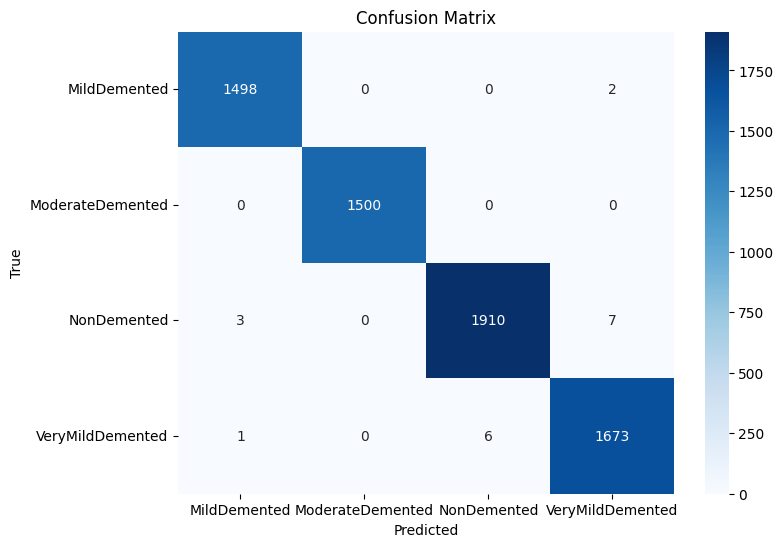

Confusion matrix saved to: /kaggle/working/results/resnet50/confusion_matrix.png
Predictions saved to: /kaggle/working/results/resnet50/test_predictions.csv
Per-class metrics saved to: /kaggle/working/results/resnet50/per_class_metrics.csv


In [19]:
# Evaluate final model on test_gen (robust, saves results)
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# 1) Verify generator
try:
    assert not getattr(test_gen, 'shuffle', False), "Set test_gen.shuffle = False when creating generator"
except AssertionError as e:
    print("Warning:", e)

steps = len(test_gen)

# 2) Quick evaluate
loss, acc = model.evaluate(test_gen, steps=steps, verbose=1)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

# 3) Predictions for detailed metrics
pred_probs = model.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

# True labels: prefer generator.classes if available
if hasattr(test_gen, 'classes'):
    y_true = test_gen.classes
else:
    # fallback: collect labels from generator
    y_true = []
    for X, y in test_gen:
        lab = y.numpy() if hasattr(y, 'numpy') else y
        y_true.extend(np.argmax(lab, axis=1))
    y_true = np.array(y_true)[:len(y_pred)]

# 4) Class names
if hasattr(test_gen, 'class_indices'):
    class_names = [k for k, v in sorted(test_gen.class_indices.items(), key=lambda x: x[1])]
else:
    class_names = [f'class_{i}' for i in range(pred_probs.shape[1])]

# 5) Reports & confusion matrix
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
os.makedirs(config.RESULTS_DIR, exist_ok=True)
plt.savefig(os.path.join(config.RESULTS_DIR, 'confusion_matrix.png'), bbox_inches='tight', dpi=150)
plt.show()
plt.close()
print(f"Confusion matrix saved to: {os.path.join(config.RESULTS_DIR, 'confusion_matrix.png')}")

# 6) Save per-sample predictions
rows = []
filenames = getattr(test_gen, 'filenames', None)
if filenames and len(filenames) >= len(y_pred):
    for fn, yt, yp in zip(filenames[:len(y_pred)], y_true, y_pred):
        rows.append({'filename': fn, 'y_true': int(yt), 'y_pred': int(yp)})
else:
    for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
        rows.append({'index': i, 'y_true': int(yt), 'y_pred': int(yp)})

df = pd.DataFrame(rows)
out_csv = os.path.join(config.RESULTS_DIR, 'test_predictions.csv')
df.to_csv(out_csv, index=False)
print(f"Predictions saved to: {out_csv}")

# 7) Save per-class precision/recall/f1
p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average=None)
summary = pd.DataFrame({
    'class': class_names,
    'precision': p,
    'recall': r,
    'f1': f,
    'support': s
})
summary.to_csv(os.path.join(config.RESULTS_DIR, 'per_class_metrics.csv'), index=False)
print(f"Per-class metrics saved to: {os.path.join(config.RESULTS_DIR, 'per_class_metrics.csv')}")